<a href="https://colab.research.google.com/github/LaysaBit/Agrupamento-Espectral/blob/main/Clusterizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Modules needed

#### 1.1 To acess Littleballoffur module

In [1]:
import os, sys 
#to be able to interact with Google Drive's operating system
from google.colab import drive 
#drive is a module that allows us use Python to interact with google drive
drive.mount('/content/gdrive') 
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')



Mounted at /content/gdrive


#### 1.2 The other modules

In [4]:
import copy
import os
import math as mt
import random
import pandas as pd
import networkx as nx        
import numpy as np
import matplotlib.pyplot as plt
from littleballoffur import RandomWalkSampler
from littleballoffur import RandomNodeSampler
from littleballoffur import RandomEdgeSampler
import sklearn
from sklearn import metrics
from sklearn.metrics import rand_score
import csv

EPSILON = 0.0000001 

### Arquivo do Grafo

In [3]:
!git clone https://github.com/lauraassis/CDP

Cloning into 'CDP'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 278 (delta 10), reused 269 (delta 8), pack-reused 0
Receiving objects: 100% (278/278), 2.48 MiB | 16.52 MiB/s, done.
Resolving deltas: 100% (10/10), done.


### Criando o grafo

In [5]:
def build_graph(graph, path):

    prelim = []                          # Lista auxiliar da função. 
    clusters_from_fil = []               # Vai guardar os clusters descritos no arquivo.
    i = 0

    file1 = open(""+path+"", mode="r", encoding='UTF-8')
    line = file1.readline().split()
    line = [int(line[x]) for x in range(len(line)-1)]
    vertices = line[0]

    for line in file1:
        prelim = line.split()

        if(prelim != []):
            if( i < vertices ):
                  graph.add_node(i, X = int(prelim[0]), Y = int(prelim[1]))    # Adiciona atributos aos vértices.
                  clusters_from_fil.append( int(prelim[2]) )                   # Guarda os clusters do arquivo.
                  i+=1
            
            else: graph.add_edge(int(prelim[0]), int(prelim[1]))       # Adiciona as arestas do grafo

    file1.close()

    return clusters_from_fil

### Separar os vértices de acordo com as entradas do vetor de Fiedler

Parâmetros:
*   Vetor de Fiedler
*   Grafo



#### Pega vértices, função auxiliar da função clusterizacao

In [6]:
def get_vertices(vector, graph):
    neg = []
    pos = []
    tot = []
    GraphNodes = list(graph.nodes())
    
    for i in range(len(vector)):
        if (vector[i] < 0):
            neg.append(GraphNodes[i])
        else:
            pos.append(GraphNodes[i])
            
    tot.append(neg)
    tot.append(pos)
    return tot

#### Busca o número de vértices e de arestas de cada cluster

In [7]:
def get_NumVNumE(lista_in, graph):
    lista_out = []
    for i in range(len(lista_in)):
        GraphInf = []
        
        H = nx.Graph()
        H = copy.deepcopy(graph.subgraph(lista_in[i]))
        
        nvert = H.number_of_nodes()
        GraphInf.append(nvert)
        
        nedges = H.number_of_edges()
        GraphInf.append(nedges)
        
        lista_out.append(GraphInf)
    return lista_out

#### Densidade do cluster; 

In [8]:
def get_density(lista_in):
  #lista_out = []          # Mudar isso aqui.
  lista_out = [v[1]/v[0] for v in lista_in]
  return lista_out

#### Calcula o vetor de Fiedler

In [9]:
def compute_fiedler(matrix):
    val,w = np.linalg.eigh(matrix)
    vet_out = [w[i][1] for i in range(len(w))]

    return vet_out

#### Clusteriza o grafo e armazena os vértices do cluster na lista 

In [10]:
def clusterizacao(graph, size, clusters, ListOfGraphs):
    Lap = nx.laplacian_matrix(graph).toarray()  
    L = [ list(Lap[i]) for i in range(len(graph)) ]
    
    Lap

    fv = compute_fiedler(L)

    #Evita erros numéricos
    for i in range(len(fv)):
        if (abs(fv[i]) <= EPSILON): 
            fv[i] = 0

    vec = get_vertices(fv, graph)

    #Separa os subgrafos de acordo com o vetor de Fiedler
    H1 = copy.deepcopy(graph.subgraph(vec[0]))
    H2 = copy.deepcopy(graph.subgraph(vec[1]))

    #Organiza os subgrafos de acordo com seus tamanhos
    if (H1.number_of_nodes() > size):
        if(nx.number_connected_components(H1) == 1):
            ListOfGraphs.append(H1)
        else:
            for c in (nx.connected_components(H1)):
                H = copy.deepcopy(H1.subgraph(c))
                if (H.number_of_nodes() > size):
                    ListOfGraphs.append(H)
                else:
                    clusters.append(list(H.nodes()))
                    
    else:
        if(len(vec[0]) != 0):
            clusters.append(vec[0])
        

    if (H2.number_of_nodes() > size):
        if(nx.number_connected_components(H2) == 1):
            ListOfGraphs.append(H2)
        else:
            for c in nx.connected_components(H2):
                H = copy.deepcopy(H2.subgraph(c))
                if (H.number_of_nodes() > size):
                    ListOfGraphs.append(H)
                else:
                    clusters.append(list(H.nodes()))
                    
    else:
        if (len(vec[1]) != 0):
            clusters.append(vec[1])
    
    return clusters, ListOfGraphs

#### Construção dos clusters

In [11]:
def BuildCluster(graph, size):
    ListOfGraphs = [graph]
    clusters     = []
    
    while (len(ListOfGraphs) != 0):
        tested_graph = ListOfGraphs[0]
        ListOfGraphs.pop(0)
        clusters, ListOfGraphs = clusterizacao(tested_graph, size, clusters, ListOfGraphs)

    return clusters

#### Desenha um cluster específico

Parâmetros:
*   lista de vertices do cluster;
*   grafo original;
*   cluster específico.





In [12]:
def draw_cluster(lista_in, graph, c, mapa):
    plt.figure(figsize=(8, 8))
    
    if ( (c < 0) or (c > len(lista_in))):
        print('cluster inexistente')
        return
    else:
        H = copy.deepcopy(graph.subgraph(lista_in[c]))

    map_aux = [ mapa[lista_in[c][i]-1] for i in range(len(lista_in[c]))]
    nx.draw(H, with_labels=True, node_color = map_aux, node_size = 900, font_size = 10, linewidths = 0.5, edge_color = 'black')
    plt.show()

#### Atribuir cores aos vértices.



*   atribui a cada cluster uma cor selecionada aleatoriamente.





In [13]:
def set_color_node(graph, lista_in):
  mapa_cores = np.zeros((len(graph),), dtype = tuple)

  for i in range(len(lista_in)): 
      color = (random.randint(0,255)/255, random.randint(0,255)/255, random.randint(0,255)/255, 1.0)
      for node in lista_in[i]:  
          mapa_cores[node-1] = color
  
  return mapa_cores

#### Grafo de Corte 

In [14]:
def GetCutGraph(graph, lista_in):
    cGraph = nx.Graph()
    cGraph = copy.deepcopy(graph)

    for c in lista_in:
        H = graph.subgraph(c)
        for e in H.edges():
            e1 = (e[1],e[0])
            for f in graph.edges():
                if (e == f):
                    cGraph.remove_edge(e[0], e[1])
                elif (e1 == f):
                    cGraph.remove_edge(e1[0], e1[1])
    return cGraph

####  Qualidade da clusterização

In [15]:
def measuring_partition(graph, lista_in): #n utiliza as coordenadas
    measure = []
    cov = nx.algorithms.community.coverage(graph,lista_in)
    measure.append(cov)
    per = nx.algorithms.community.performance(graph,lista_in)
    measure.append(per)
    mod = nx.algorithms.community.modularity(graph,lista_in)
    measure.append(mod)
    return measure

### Pega número de vértices, número de arestas e quantidade de cluster.

In [16]:
def get_parameters(path):
  
  file1 = open(""+path+"", mode="r", encoding='UTF-8')
  line = file1.readline().split()
  line = [int(line[x]) for x in range(len(line)-1)]

  vert, edges, qtd_clusters = line[0:3]
  
  cluster_size = 31
  return vert, edges, qtd_clusters, cluster_size

  ### Rand Index
    



In [17]:
def rand_index(subgraphcluster, subgraphx, clusters_from_file1):
        
    a = len(subgraphx.nodes())
    indexSubgraphCluster = np.zeros(shape=a, dtype=int)
    indexOriginalCluster = np.zeros(shape=a, dtype=int)    

    nodesubgraph = list(subgraphx.nodes())
    a = len(nodesubgraph)
    b = len(subgraphcluster)
    c = 0
    flag = 0
    for i in range(0,a):
        d = nodesubgraph[i] 
        
        for j in range(0,b):
          e = len(subgraphcluster[j])
          
          for k in range(0,e):
              if(subgraphcluster[j][k] == d):
                  indexSubgraphCluster[c] = j
                  c+=1
                  flag = 1
                  break
          if(flag == 1):
              flag = 0           
              break 

    b = len(clusters_from_file1)
    c = 0
    flag = 0 
    for i in range(0,a):
        d = nodesubgraph[i]
        indexOriginalCluster[c] = clusters_from_file1[d]
        c+=1

    c = rand_score(indexOriginalCluster,indexSubgraphCluster)
    return c

### Faz a diferença entre as medidas

In [18]:
def difference(m1,m2,m3):
    a = m1 - m2
    b = m1 - m3
    c = m2 - m3

    result = (a+b+c)/3
    return result

### Pega originalCluster

In [19]:
def get_originalCluster(clusters_from_file1):
  a = max(clusters_from_file1)
  originalCluster1 = [ [] for _ in range(a+1)]

  c = len(clusters_from_file1)
  for i in range(c):
      originalCluster1[clusters_from_file1[i]].append(i)

  return originalCluster1

### Grafo gerado pelo código, grafo do arquivo e seus clusters

*   nv = número de vértices
*   ne = número de arestas
*   cluster_size = quantidade máxima de vértices por cluster





In [20]:
      G         = nx.Graph()
      G_from_file = nx.Graph()
      cut_graph = nx.Graph()    
      clusters_from_file = []

      nv, ne, qtd_clusters, cluster_size = get_parameters("/content/CDP/T13/B1100b.txt") 

      if (cluster_size > 0):
            clusters_from_file = build_graph(G, "/content/CDP/T13/B1100b.txt")
      else:
            print("Cluster size error!")
      
      node_positions = {node[0]: (node[1]['X'], node[1]['Y']) for node in G.nodes(data=True)}
      
      originalCluster = get_originalCluster(clusters_from_file)
      
      cluster_from_code   = BuildCluster(G, cluster_size)  

      m = measuring_partition(G,originalCluster)
      print("Medidas de qualidade com base no grafo do arquivo: ")
      print('Cobertura '   , round(m[0],2))           
      print('Performance: ' , round(m[1],2))           
      print('Modularidade: ', round(m[2],2))           
      print('Diferenca entre as medidas: ', difference( round(m[0],2), round(m[1],2), round(m[2],2) ) ) 
      print()

      n = measuring_partition(G,cluster_from_code)
      print("Medidas de qualidade com base no grafo produzido:")
      print('Cobertura: '   , round(n[0],2))           
      print('Performance: ' , round(n[1],2))           
      print('Modularidade: ', round(n[2],2))           
      print('Diferenca entre as medidas: ', difference( round(n[0],2), round(n[1],2), round(n[2],2) ) )

      print()
      print("Rand Index entre clusters do arquivo e o cluster produzido: ", rand_index(cluster_from_code, G, clusters_from_file))
      print()

      Cluster_NumV_NumE = get_NumVNumE(originalCluster,G)
      ClusterDensity = get_density(Cluster_NumV_NumE)
          
      #color_map = set_color_node(G,originalCluster)
      #cut_graph = GetCutGraph(G,originalCluster)

Medidas de qualidade com base no grafo do arquivo: 
Cobertura  0.85
Performance:  0.94
Modularidade:  0.78
Diferenca entre as medidas:  0.046666666666666634

Medidas de qualidade com base no grafo produzido:
Cobertura:  0.73
Performance:  0.98
Modularidade:  0.71
Diferenca entre as medidas:  0.013333333333333345

Rand Index entre clusters do arquivo e o cluster produzido:  0.9463339290078201



### Subgrafo Induzido


*   Suas medidas de qualidade;
*   Rand Index entre o cluster do subgrafo e o cluster original.



In [21]:
    model = RandomWalkSampler()
    subgraph1 = model.sample(G) 

    subgraphCluster = BuildCluster(subgraph1, cluster_size)

    n = measuring_partition(subgraph1, subgraphCluster)
    print("Cluster size: ", cluster_size)
    print('Cobertura: '   , round(n[0],2))
    print('Performance: ' , round(n[1],2))
    print('Modularidade: ', round(n[2],2))
    print('Diferenca entre as medidas: ', difference( round(n[0],2), round(n[1],2), round(n[2],2) ) )
    print('Rand Index entre o cluster do gabarito e cluster do subgrafo: ', rand_index(subgraphCluster, subgraph1, clusters_from_file))
    print()

    #subCluster_NumV_NumE = get_NumVNumE(subgraphCluster, G)
    #subClusterDensity    = get_density(subCluster_NumV_NumE)

    # print(" Supergraphgraph Numv_NumE ", Cluster_NumV_NumE)
    # print(" Supergraph density ", ClusterDensity)
    # print(" Subgraph Numv_NumE ", subCluster_NumV_NumE)
    # print(" Subgraph density ", subClusterDensity)

    #subColor_map = set_color_node(subgraph1, subgraphCluster) # A partir do valor 275 não tem como fazer visualização do grafo por meio do color_map atual.
    #subCut_graph = GetCutGraph(subgraph1, subgraphCluster)


Cluster size:  31
Cobertura:  0.86
Performance:  0.83
Modularidade:  0.66
Diferenca entre as medidas:  0.1333333333333333
Rand Index entre o cluster do gabarito e cluster do subgrafo:  0.5977777777777777



### Plottings do Supergrafo

#### 1.1 Desenha Grafo

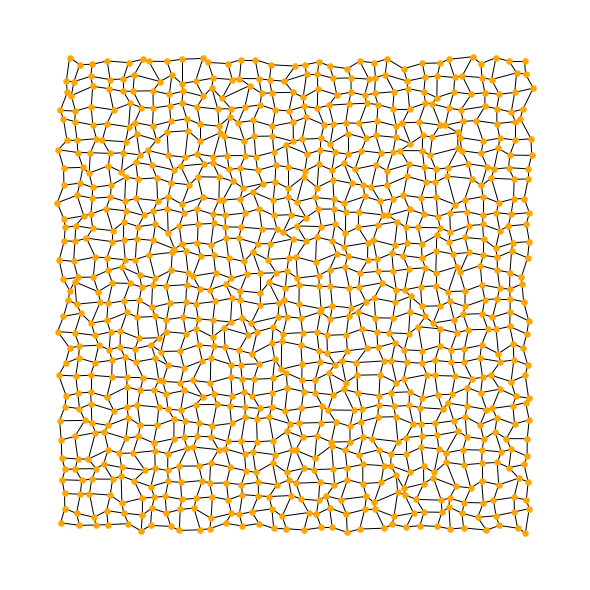

In [22]:
plt.figure(figsize=(8, 8))
pos = node_positions
nx.draw(G, with_labels=False, pos = pos, node_color = "orange", node_size = 40, linewidths = 0.2, 
        edge_color = 'black',width = 1.0, font_color = 'blue')
plt.show()

#### 1.2 Desenha Grafo com Clusters

In [23]:
plt.figure(figsize=(8, 8))

options = {'with_labels': True, 
            'node_color' : color_map, 
            'node_size' : 1100,
            'font_size' : 10, 
            'linewidths' : 1.0,
            'edge_color' : 'black'}
#shells = originalCluster
#nx.draw_shell(G, nlist=shells, **options)

nx.draw(G, with_labels=False, pos = pos, node_color = color_map, node_size = 40, font_size = 10, width = 1.5, edge_color = 'gray')
plt.show()

NameError: ignored

<Figure size 576x576 with 0 Axes>

#### 1.3 Desenha os clusters



In [ ]:
for i in range(0, len(originalCluster)): #Será que deveriamos usar originalCluster ou clusters_from_file aqui?
          draw_cluster(originalCluster, G, i, color_map) 

#### 1.4 Desenha Grafo de Corte

In [ ]:
plt.figure(figsize=(8, 8))
options = {'with_labels': True, 
            'node_color' : color_map, 
            'node_size' : 1000,
            'font_size' : 10, 
            'linewidths' : 1.5,
            'edge_color' : 'gray'}
# shells = originalCluster
# nx.draw_shell(cut_graph, nlist=shells, **options)
nx.draw(cut_graph, pos = pos, with_labels=False, node_color = color_map, node_size = 40, width = 2.0, edge_color = 'gray')
plt.show()

### Plottings do subgrafo induzido

#### 2.1 Desenhando o subgrafo induzido

In [ ]:
node_positionsub = {node[0]: (node[1]['X'], node[1]['Y']) for node in subgraph1.nodes(data=True)}

plt.figure(figsize=(8, 8))
nx.draw(subgraph1, with_labels=False, pos = node_positionsub, node_color = "orange", node_size = 40, linewidths = 0.2, 
        edge_color = 'black',width = 1.0, font_color = 'blue')
plt.show()


#### 2.2 Desenha subgrafo com clusters (!)

In [ ]:
plt.figure(figsize=(8, 8))
options = {'with_labels': True, 
            'node_color' : subColor_map, 
            'node_size' : 1100,
            'font_size' : 10, 
            'linewidths' : 1.0,
            'edge_color' : 'black'}
#shells = originalCluster
#nx.draw_shell(G, nlist=shells, **options)              #Usa-se ou a linha 272 ou a 273.
nx.draw(subgraph, with_labels=False, pos = node_positionsub, node_color = subColor_map, node_size = 40, font_size = 10, width = 1.5, edge_color = 'gray')
plt.show()

#### 2.3 Plot clusters do subgrafo induzido (!)

In [ ]:
#  for i in range(0, len(subgraphClusters)):
#         draw_cluster(subgraphClusters, subgraph, i, subColor_map) 


#### 2.4 Grafo de corte do induzido (!)



In [ ]:
# plt.figure(figsize=(8, 8))
# options = {'with_labels': True, 
#             'node_color' : subColor_map, 
#             'node_size' : 1000,
#             'font_size' : 10, 
#             'linewidths' : 1.5,
#             'edge_color' : 'gray'}
# #shells = originalCluster
# #nx.draw_shell(cut_graph, nlist=shells, **options)
# nx.draw(subCut_graph, pos = pos, with_labels=True, node_color = subColor_map, node_size = 900, width = 2.0, edge_color = 'gray')
# plt.show()

## Análise do subgrafo
Análise das:
*   Medidas de Qualidade
*   Rand Index em relação aos arquivos base https://github.com/lauraassis/CDP

Agrupado pelo tamanho de nó, 512 ou 1024, e pelas topologias: 50 (spanning tree), 25 (sparse grid), 00 (full grid) respectivamente no código.






### Análise com base no grafo original

#### Para grafos de 512 vértices






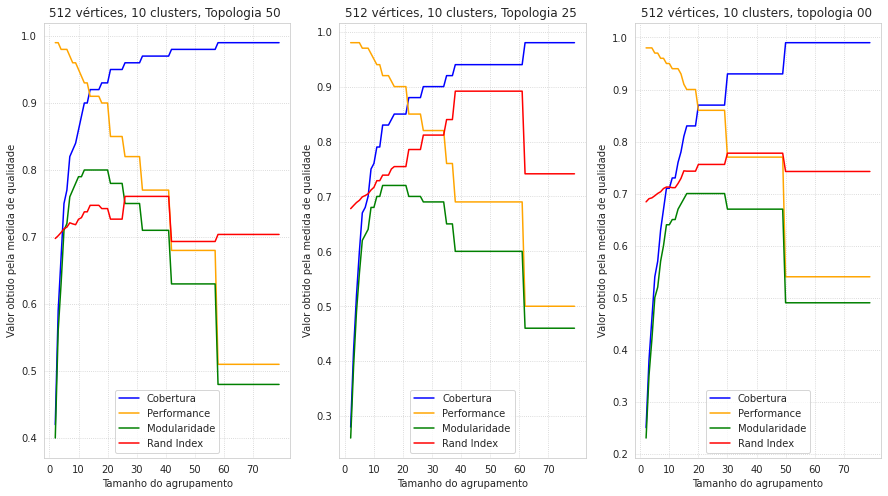

In [38]:
data = []
Gx = nx.Graph()
nv2, ne2, qtd_clusters2, cluster_size = get_parameters("/content/CDP/T12/A2250e.txt") 

if (cluster_size > 0):
      clusters_from_file2 = build_graph(Gx, "/content/CDP/T12/A2250e.txt")
else:
      print("Cluster size error!")

cobertura    = np.zeros(78, dtype=float)
performance  = np.zeros(78, dtype=float)
modularidade = np.zeros(78, dtype=float)
rand_indexu  = np.zeros(78, dtype=float)

c = 0
for i in range(2,80,1):
#     # Criar o subgrafo
     model = RandomWalkSampler()
     subgraphz = model.sample(Gx) 

#     # Criar clusters do subgrafo
     subgraphCluster1 = BuildCluster(subgraphz, i)
     
     n = measuring_partition(subgraphz, subgraphCluster1)
     cobertura[c]    = round(n[0],2)
     performance[c]  = round(n[1],2)
     modularidade[c] = round(n[2],2)
     rand_indexu[c]  = rand_index(subgraphCluster1, subgraphz, clusters_from_file2)
     data.append([ i, modularidade[c], rand_indexu[c], cobertura[c], performance[c] ])
     c+=1
    
plt.figure(figsize = (15,8))
plt.subplot(1,3,1)
x = np.arange(2,80,1)
plt.plot(x, cobertura, label    = 'Cobertura', color    ='blue')
plt.plot(x, performance, label  = 'Performance', color  = 'orange')
plt.plot(x, modularidade, label = 'Modularidade', color = 'green')
plt.plot(x, rand_indexu, label  = 'Rand Index', color   = 'red')
plt.legend(loc = 8)
plt.grid(True, linestyle=':')
plt.title('512 vértices, 10 clusters, Topologia 50 ')
plt.xlabel('Tamanho do agrupamento')
plt.ylabel('Valor obtido pela medida de qualidade')
plt.xticks(np.arange(0, max(x), 10.0))

with open('/content/gdrive/MyDrive/A2250e.csv', 'w', newline='') as file:
    fieldnames = ['Cluster_size', 'Modularidade', 'Rand Index', 'Cobertura', 'Performance']
    writer = csv.writer(file)

    writer.writerow(fieldnames)
    writer.writerows(data)

data.clear()

Gh = nx.Graph()
nv2, ne2, qtd_clusters2, cluster_size = get_parameters("/content/CDP/T11/A2275a.txt") 

if (cluster_size > 0):
      clusters_from_file2 = build_graph(Gh, "/content/CDP/T11/A2275a.txt")
else:
      print("Cluster size error!")

cobertura    = np.zeros(78, dtype=float)
performance  = np.zeros(78, dtype=float)
modularidade = np.zeros(78, dtype=float)
rand_indexu  = np.zeros(78, dtype=float)
            

c = 0
for i in range(2,80,1):
#     # Criar o subgrafo
     model = RandomWalkSampler()
     subgraphz = model.sample(Gh) 

#     # Criar clusters do subgrafo
     subgraphCluster2 = BuildCluster(subgraphz, i)
    
     n = measuring_partition(subgraphz, subgraphCluster2)
     cobertura[c]    = round(n[0],2)
     performance[c]  = round(n[1],2)
     modularidade[c] = round(n[2],2)
     rand_indexu[c]  = rand_index(subgraphCluster2, subgraphz, clusters_from_file2)
     data.append([ i, modularidade[c], rand_indexu[c], cobertura[c], performance[c] ])
     c+=1
     
plt.subplot(1,3,2)
x = np.arange(2,80,1)
plt.plot(x, cobertura, label    = 'Cobertura', color    = 'blue')
plt.plot(x, performance, label  = 'Performance', color  = 'orange')
plt.plot(x, modularidade, label = 'Modularidade', color = 'green')
plt.plot(x, rand_indexu, label  = 'Rand Index', color   = 'red')
plt.legend(loc = 8)
plt.grid(True, linestyle=':')
plt.title('512 vértices, 10 clusters, Topologia 25 ')
plt.xlabel('Tamanho do agrupamento')
plt.ylabel('Valor obtido pela medida de qualidade')
plt.xticks(np.arange(0, max(x), 10.0))

with open('/content/gdrive/MyDrive/A2275a.csv', 'w', newline='') as file:
    fieldnames = ['Cluster_size', 'Modularidade', 'Rand Index', 'Cobertura', 'Performance']
    writer = csv.writer(file)

    writer.writerow(fieldnames)
    writer.writerows(data)

data.clear()

Gn = nx.Graph()
nv2, ne2, qtd_clusters2, cluster_size = get_parameters("/content/CDP/T1/A1100a.txt") 

if (cluster_size > 0):
      clusters_from_file2 = build_graph(Gn, "/content/CDP/T1/A1100a.txt")
else:
      print("Cluster size error!")

cobertura    = np.zeros(78, dtype=float)
performance  = np.zeros(78, dtype=float)
modularidade = np.zeros(78, dtype=float)
rand_indexu  = np.zeros(78, dtype=float)
            
c = 0
for i in range(2,80,1):
#     # Criar o subgrafo
     model = RandomWalkSampler()
     subgraphz = model.sample(Gn) 

#     # Criar clusters do subgrafo
     subgraphCluster2 = BuildCluster(subgraphz, i)
    
     n = measuring_partition(subgraphz, subgraphCluster2)
     cobertura[c]    = round(n[0],2)
     performance[c]  = round(n[1],2)
     modularidade[c] = round(n[2],2)
     rand_indexu[c]  = rand_index(subgraphCluster2, subgraphz, clusters_from_file2)
     data.append([ i, modularidade[c], rand_indexu[c], cobertura[c], performance[c] ])
     c+=1
     
plt.subplot(1,3,3)
x = np.arange(2,80,1)
plt.plot(x, cobertura, label    = 'Cobertura', color    = 'blue')
plt.plot(x, performance, label  = 'Performance', color  = 'orange')
plt.plot(x, modularidade, label = 'Modularidade', color = 'green')
plt.plot(x, rand_indexu, label  = 'Rand Index', color   = 'red')
plt.legend(loc = 8)
plt.grid(True, linestyle=':')
plt.title('512 vértices, 10 clusters, topologia 00 ')
plt.xlabel('Tamanho do agrupamento')
plt.ylabel('Valor obtido pela medida de qualidade')
plt.xticks(np.arange(0, max(x), 10.0))

plt.show()

with open('/content/gdrive/MyDrive/A1100a.csv', 'w', newline='') as file:
    fieldnames = ['Cluster_size', 'Modularidade', 'Rand Index', 'Cobertura', 'Performance']
    writer = csv.writer(file)

    writer.writerow(fieldnames)
    writer.writerows(data)

data.clear()


#### Para grafos de 1024 vértices.

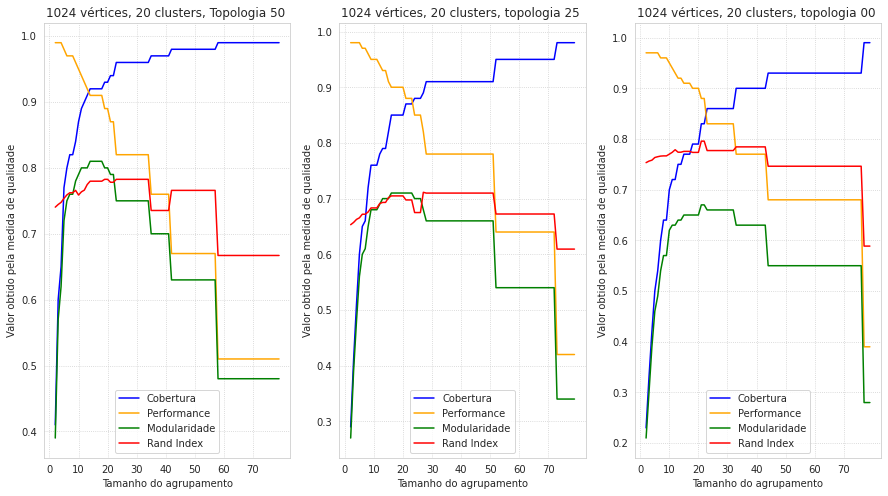

In [41]:
data = []
Gm = nx.Graph()
nv2, ne2, qtd_clusters2, cluster_size = get_parameters("/content/CDP/T24/B2250a.txt") 

if (cluster_size > 0):
      clusters_from_file2 = build_graph(Gm, "/content/CDP/T24/B2250a.txt")
else:
      print("Cluster size error!")

cobertura    = np.zeros(78, dtype=float)
performance  = np.zeros(78, dtype=float)
modularidade = np.zeros(78, dtype=float)
rand_indexu  = np.zeros(78, dtype=float)

c = 0
for i in range(2,80,1):
#     # Criar o subgrafo
     model = RandomWalkSampler()
     subgraphz = model.sample(Gm) 

#     # Criar clusters do subgrafo
     subgraphCluster1 = BuildCluster(subgraphz, i)
    
     n = measuring_partition(subgraphz, subgraphCluster1)
     cobertura[c]    = round(n[0],2)
     performance[c]  = round(n[1],2)
     modularidade[c] = round(n[2],2)
     rand_indexu[c]  = rand_index(subgraphCluster1, subgraphz, clusters_from_file2)
     data.append([ i, modularidade[c], rand_indexu[c], cobertura[c], performance[c] ])
     c+=1

plt.figure(figsize = (15,8))
plt.subplot(1,3,1)
x = np.arange(2,80,1)
plt.plot(x, cobertura, label    = 'Cobertura', color    ='blue')
plt.plot(x, performance, label  = 'Performance', color  = 'orange')
plt.plot(x, modularidade, label = 'Modularidade', color = 'green')
plt.plot(x, rand_indexu, label  = 'Rand Index', color   = 'red')
plt.legend(loc = 8)
plt.grid(True, linestyle=':')
plt.title('1024 vértices, 20 clusters, Topologia 50 ')
plt.xlabel('Tamanho do agrupamento')
plt.ylabel('Valor obtido pela medida de qualidade')
plt.xticks(np.arange(0, max(x), 10.0))

with open('/content/gdrive/MyDrive/B2250a.csv', 'w', newline='') as file:
    fieldnames = ['Cluster_size', 'Modularidade', 'Rand Index', 'Cobertura', 'Performance']
    writer = csv.writer(file)

    writer.writerow(fieldnames)
    writer.writerows(data)

data.clear()

Gt = nx.Graph()
nv2, ne2, qtd_clusters2, cluster_size = get_parameters("/content/CDP/T20/B2175a.txt") 

if (cluster_size > 0):
      clusters_from_file2 = build_graph(Gt, "/content/CDP/T20/B2175a.txt")
else:
      print("Cluster size error!")

cobertura    = np.zeros(78, dtype=float)
performance  = np.zeros(78, dtype=float)
modularidade = np.zeros(78, dtype=float)
rand_indexu  = np.zeros(78, dtype=float)

c = 0
for i in range(2,80,1):
#     # Criar o subgrafo
     model = RandomWalkSampler()
     subgraphz = model.sample(Gt) 

#     # Criar clusters do subgrafo
     subgraphCluster2 = BuildCluster(subgraphz, i)
    
     n = measuring_partition(subgraphz, subgraphCluster2)
     cobertura[c] = round(n[0],2)
     performance[c] = round(n[1],2)
     modularidade[c] = round(n[2],2)
     rand_indexu[c] = rand_index(subgraphCluster2, subgraphz, clusters_from_file2)
     data.append([ i, modularidade[c], rand_indexu[c], cobertura[c], performance[c] ])
     c+=1

plt.subplot(1,3,2)
x = np.arange(2,80,1)
plt.plot(x,cobertura, label    = 'Cobertura', color    ='blue')
plt.plot(x, performance, label = 'Performance', color  = 'orange')
plt.plot(x,modularidade, label = 'Modularidade', color = 'green')
plt.plot(x,rand_indexu, label  = 'Rand Index', color   = 'red')
plt.legend(loc = 8)
plt.grid(True, linestyle=':')
plt.title('1024 vértices, 20 clusters, topologia 25 ')
plt.xlabel('Tamanho do agrupamento')
plt.ylabel('Valor obtido pela medida de qualidade')
plt.xticks(np.arange(0, max(x), 10.0))

with open('/content/gdrive/MyDrive/B2175a.csv', 'w', newline='') as file:
    fieldnames = ['Cluster_size', 'Modularidade', 'Rand Index', 'Cobertura', 'Performance']
    writer = csv.writer(file)

    writer.writerow(fieldnames)
    writer.writerows(data)

data.clear()

Go = nx.Graph()
nv2, ne2, qtd_clusters2, cluster_size = get_parameters("/content/CDP/T22/B2200a.txt") 

if (cluster_size > 0):
      clusters_from_file2 = build_graph(Go, "/content/CDP/T22/B2200a.txt")
else:
      print("Cluster size error!")

cobertura    = np.zeros(78, dtype=float)
performance  = np.zeros(78, dtype=float)
modularidade = np.zeros(78, dtype=float)
rand_indexu  = np.zeros(78, dtype=float)
            

c = 0
for i in range(2,80,1):
#     # Criar o subgrafo
     model = RandomWalkSampler()
     subgraphz = model.sample(Go) 

#     # Criar clusters do subgrafo
     subgraphCluster2 = BuildCluster(subgraphz, i)
    
     n = measuring_partition(subgraphz, subgraphCluster2)
     cobertura[c]    = round(n[0],2)
     performance[c]  = round(n[1],2)
     modularidade[c] = round(n[2],2)
     rand_indexu[c]  = rand_index(subgraphCluster2, subgraphz, clusters_from_file2)
     data.append([ i, modularidade[c], rand_indexu[c], cobertura[c], performance[c] ])
     c+=1

plt.subplot(1,3,3)
x = np.arange(2,80,1)
plt.plot(x, cobertura, label    = 'Cobertura', color    = 'blue')
plt.plot(x, performance, label  = 'Performance', color  = 'orange')
plt.plot(x, modularidade, label = 'Modularidade', color = 'green')
plt.plot(x, rand_indexu, label  = 'Rand Index', color   = 'red')
plt.legend(loc = 8)
plt.grid(True, linestyle=':')
plt.title('1024 vértices, 20 clusters, topologia 00 ')
plt.xlabel('Tamanho do agrupamento')
plt.ylabel('Valor obtido pela medida de qualidade')
plt.xticks(np.arange(0, max(x), 10.0))

plt.show()

with open('/content/gdrive/MyDrive/B2200a.csv', 'w', newline='') as file:
    fieldnames = ['Cluster_size', 'Modularidade', 'Rand Index', 'Cobertura', 'Performance']
    writer = csv.writer(file)
    writer.writerow(fieldnames)
    writer.writerows(data)

data.clear()

